In [1]:
# forecasting 1 month ahead by multi step forecasting:

In [2]:
!pip install statsmodels
!pip install openpyxl
!pip install scikit-learn
!pip install matplotlib
!pip install xgboost
!pip install catboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
#from google.colab import files
# Set default figure background to white
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'

from datetime import timedelta

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
filepath = "ods001.csv"
data = pd.read_csv(filepath, delimiter=";")[749:][::-1].reset_index().drop("index", axis=1)

In [5]:
data["Datetime"] = pd.to_datetime(data["Datetime"], errors='coerce', utc=True)
data["Datetime"] = data["Datetime"].dt.tz_convert("UTC")

In [6]:
data['Total Load'] = data['Total Load'].interpolate(method='linear')

In [7]:
data["Year"] = [i.year for i in data["Datetime"]]
data["Month"] = [i.month for i in data["Datetime"]]
data["Day"] = [i.day for i in data["Datetime"]]
data["Hour"] = [i.hour for i in data["Datetime"]]
data["Minute"] = [i.minute for i in data["Datetime"]]
data["Season"] = data["Month"]//4

In [8]:
data["Lockdown"] = 0

In [9]:
data.loc[182784:187296, "Lockdown"] = 1
data.loc[204388:208804, "Lockdown"] = 1
data.loc[212260:247300, "Lockdown"] = 1

In [10]:
data["Difference with previous load"] = [0] + list(np.array(data["Total Load"][1:].to_list()) - np.array(data["Total Load"][:-1].to_list()))

In [11]:
# Get the latest date in the dataset
latest_date = data['Datetime'].max()

# Define the date 13 months before the latest date
thirteen_months_ago = latest_date - pd.DateOffset(months=13)

# Filter the dataset to include only the last 13 months of data
data_last_thirteen_months = data[data['Datetime'] >= thirteen_months_ago].reset_index(drop=True)

# Print the number of rows in the filtered dataset to confirm
print(f"Number of entries in the last 13 months: {len(data_last_thirteen_months)}")


Number of entries in the last 13 months: 38113


In [12]:
data_last_thirteen_months.head()

,Datetime,Resolution code,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Year,Month,Day,Hour,Minute,Season,Lockdown,Difference with previous load
0,2023-07-26 02:30:00+00:00,PT15M,6389.81,6439.06,6068.35,6809.78,6582.84,6226.49,6939.20,6644.49,2023,7,26,2,30,1,0,104.63
1,2023-07-26 02:45:00+00:00,PT15M,6437.99,6472.44,6099.80,6845.08,6624.66,6266.04,6983.28,6688.08,2023,7,26,2,45,1,0,48.18
2,2023-07-26 03:00:00+00:00,PT15M,6521.73,6666.52,6300.08,7032.95,6823.95,6470.57,7177.33,6863.56,2023,7,26,3,0,1,0,83.74
3,2023-07-26 03:15:00+00:00,PT15M,6583.95,6712.90,6343.92,7081.89,6859.86,6504.62,7215.09,6878.76,2023,7,26,3,15,1,0,62.22
4,2023-07-26 03:30:00+00:00,PT15M,6627.52,6778.45,6405.87,7151.04,6922.00,6563.55,7280.45,6942.90,2023,7,26,3,30,1,0,43.57


In [13]:
data_last_thirteen_months.tail()

,Datetime,Resolution code,Total Load,Most recent forecast,Most recent P10,Most recent P90,Day-ahead 6PM forecast,Day-ahead 6PM P10,Day-ahead 6PM P90,Week-ahead forecast,Year,Month,Day,Hour,Minute,Season,Lockdown,Difference with previous load
38108,2024-08-26 01:30:00+00:00,PT15M,6709.33,6901.54,6734.68,7068.40,6814.75,6556.32,7073.17,6860.06,2024,8,26,1,30,2,0,-70.66
38109,2024-08-26 01:45:00+00:00,PT15M,6841.40,6880.89,6714.53,7047.25,6794.36,6536.71,7052.01,6838.49,2024,8,26,1,45,2,0,132.07
38110,2024-08-26 02:00:00+00:00,PT15M,6842.97,6887.46,6721.35,7053.57,6921.37,6664.11,7178.63,6948.82,2024,8,26,2,0,2,0,1.57
38111,2024-08-26 02:15:00+00:00,PT15M,6905.57,6896.76,6730.43,7063.09,6930.71,6673.11,7188.32,6937.10,2024,8,26,2,15,2,0,62.60
38112,2024-08-26 02:30:00+00:00,PT15M,6885.74,6910.04,6743.39,7076.69,6944.06,6685.96,7202.16,6964.77,2024,8,26,2,30,2,0,-19.83


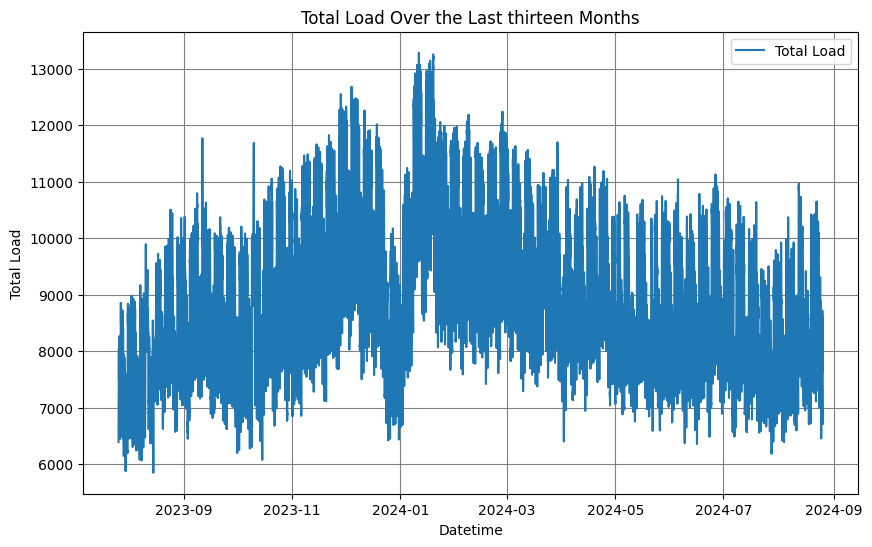

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(data_last_thirteen_months['Datetime'], data_last_thirteen_months['Total Load'], label='Total Load')
plt.title('Total Load Over the Last thirteen Months')
plt.xlabel('Datetime')
plt.ylabel('Total Load')
plt.legend()
plt.show()


considering 26 July 2024, 2:30:00 - 26 Aug 2024 2:30:00. This period is 31 days. the number of sample per day is : 24 h * 4 =96. the number of samples in one month is: 31 * 96 = 2976.

In [15]:
# Calculate the number of samples to remove (384 samples for 4 days with 15-minute intervals)
samples_to_remove = 2976

# Exclude the last one month from the dataframe
data_last_thirteen_months_filtered = data_last_thirteen_months[:-samples_to_remove].reset_index(drop=True)

# Print the number of rows in the filtered dataset to confirm
print(f"Number of entries after removing the last one month: {len(data_last_thirteen_months_filtered)}")

# Display the first and last few rows of the filtered dataframe
#print(data_last_twelve_months_filtered.head())
print(data_last_thirteen_months_filtered['Datetime'].tail())




Number of entries after removing the last one month: 35137
35132   2024-07-26 01:30:00+00:00
35133   2024-07-26 01:45:00+00:00
35134   2024-07-26 02:00:00+00:00
35135   2024-07-26 02:15:00+00:00
35136   2024-07-26 02:30:00+00:00
Name: Datetime, dtype: datetime64[ns, UTC]


In [16]:
remaining_data = data_last_thirteen_months_filtered

In [17]:
remaining_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35137 entries, 0 to 35136
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   Datetime                       35137 non-null  datetime64[ns, UTC]
 1   Resolution code                35137 non-null  object             
 2   Total Load                     35137 non-null  float64            
 3   Most recent forecast           35137 non-null  float64            
 4   Most recent P10                35137 non-null  float64            
 5   Most recent P90                35137 non-null  float64            
 6   Day-ahead 6PM forecast         35137 non-null  float64            
 7   Day-ahead 6PM P10              35137 non-null  float64            
 8   Day-ahead 6PM P90              35137 non-null  float64            
 9   Week-ahead forecast            34945 non-null  float64            
 10  Year                  

In [18]:
# Define the number of lags (how many previous 15-minute intervals you want to use as features)
num_lags = 80
# Create lag features for 'Total Load' based on 15-minute intervals
for lag in range(1, num_lags + 1):
    remaining_data[f'lag_{lag}'] = remaining_data['Total Load'].shift(lag)



In [19]:
# Split remaining_data into training and testing sets
train_size = int(len(remaining_data) * 0.8)
data_train = remaining_data[:train_size]
data_test = remaining_data[train_size:]

# Separate features and target variable for training
feature_cols = [f'lag_{lag}' for lag in range(1, num_lags + 1)]
X_train = data_train[feature_cols]
y_train = data_train['Total Load']

# Separate features and target variable for testing
X_test = data_test[feature_cols]
y_test = data_test['Total Load']

In [20]:
#X_test.info()

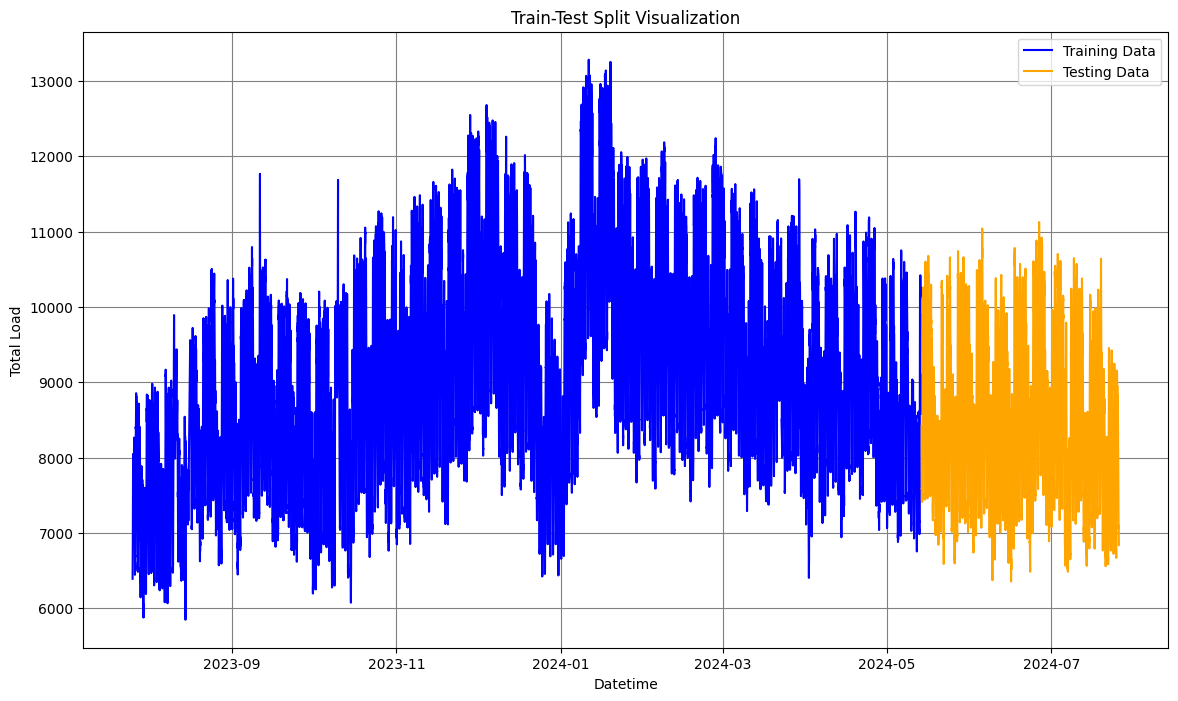

In [21]:
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(data_train['Datetime'], data_train['Total Load'], label='Training Data', color='blue')

# Plot testing data
plt.plot(data_test['Datetime'], data_test['Total Load'], label='Testing Data', color='orange')

# Plot unseen data (last 24 hours, out-of-sample)
#plt.plot(unseen_data['Datetime'], unseen_data['Total Load'], label='Unseen Data', color='red')

# Add labels and title
plt.xlabel('Datetime')
plt.ylabel('Total Load')
plt.title('Train-Test Split Visualization')
plt.legend()

# Show plot
plt.show()


In [22]:
# LightGBM
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for LightGBM
param_dist = {
    'num_leaves': [31, 50, 70],           # Number of leaves in one tree
    'max_depth': [-1, 10, 20],            # Maximum depth of the tree
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'n_estimators': [100, 200, 300],      # Number of boosting rounds
    'subsample': [0.8, 1.0],              # Fraction of samples to be used for each tree
    'colsample_bytree': [0.8, 1.0],       # Fraction of features to be used for each tree
    'reg_alpha': [0, 0.1, 0.5],           # L1 regularization term
    'reg_lambda': [0, 0.1, 0.5],          # L2 regularization term
}

# Initialize the LightGBM Regressor
lgbm = LGBMRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=20,              # Number of parameter settings sampled
    cv=2,                   # 2-fold cross-validation
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    verbose=2,
    n_jobs=-1,              # Use all available cores for parallel processing
    random_state=42         # For reproducibility
)

# Perform random search to find the best parameters
random_search.fit(X_train, y_train)

# Get the best model
best_lgbm = random_search.best_estimator_

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found: ", random_search.best_params_)

# Evaluate the model on the test set using the best parameters
y_test_pred = best_lgbm.predict(X_test)

# Calculate evaluation metrics for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Mean Squared Error (MSE): {mse_test}")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse_test}")
print(f"Test Set Mean Absolute Error (MAE): {mae_test}")
print(f"Test Set R^2 Score: {r2_test}")

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20400
[LightGBM] [Info] Number of data points in the train set: 28109, number of used features: 80
[LightGBM] [Info] Start training from score 9244.331847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Test Set Mean Squared Error (MSE): 6627.512697886506
Test Set Root Mean Squared Error (RMSE): 81.40953689762955
Test Set Mean Absolute Error (MAE): 62.47340153077294
Test Set R^2 Score: 0.9943209643252862


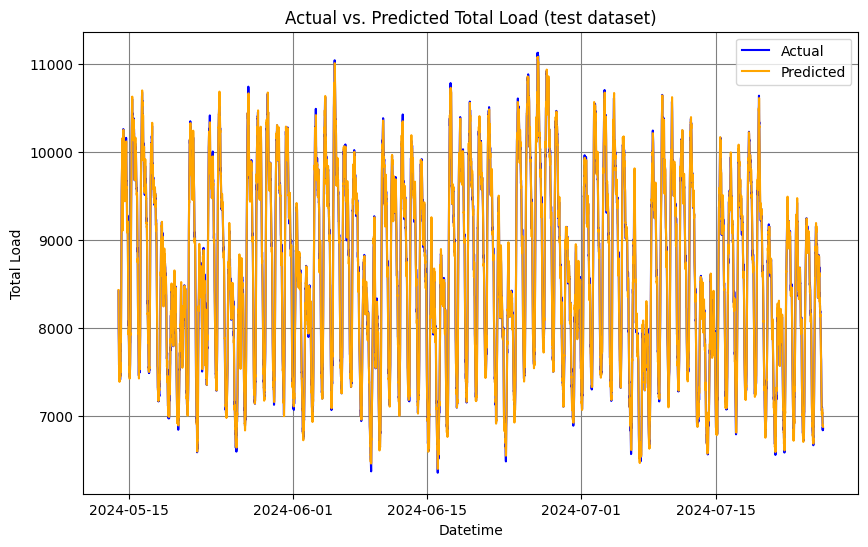

In [23]:
# plot y_test and y_test_pred
plt.figure(figsize=(10, 6))
plt.plot(data_test['Datetime'], y_test, label='Actual', color='blue')
plt.plot(data_test['Datetime'], y_test_pred, label='Predicted', color='orange')
plt.title('Actual vs. Predicted Total Load (test dataset)')
plt.xlabel('Datetime')
plt.ylabel('Total Load')
plt.legend()
plt.show()

                      Datetime  Predicted Load
0    2024-07-26 02:45:00+00:00     6875.867522
1    2024-07-26 03:00:00+00:00     6897.059883
2    2024-07-26 03:15:00+00:00     6936.766858
3    2024-07-26 03:30:00+00:00     6989.780207
4    2024-07-26 03:45:00+00:00     7099.368020
...                        ...             ...
2971 2024-08-26 01:30:00+00:00     6945.267762
2972 2024-08-26 01:45:00+00:00     6678.257660
2973 2024-08-26 02:00:00+00:00     6681.490772
2974 2024-08-26 02:15:00+00:00     6657.510175
2975 2024-08-26 02:30:00+00:00     6674.322290

[2976 rows x 2 columns]
                      Datetime  Predicted Load  Actual Load  Difference
0    2024-07-26 02:45:00+00:00     6875.867522      6858.98  -16.887522
1    2024-07-26 03:00:00+00:00     6897.059883      6953.76   56.700117
2    2024-07-26 03:15:00+00:00     6936.766858      7016.03   79.263142
3    2024-07-26 03:30:00+00:00     6989.780207      7050.98   61.199793
4    2024-07-26 03:45:00+00:00     7099.368020     

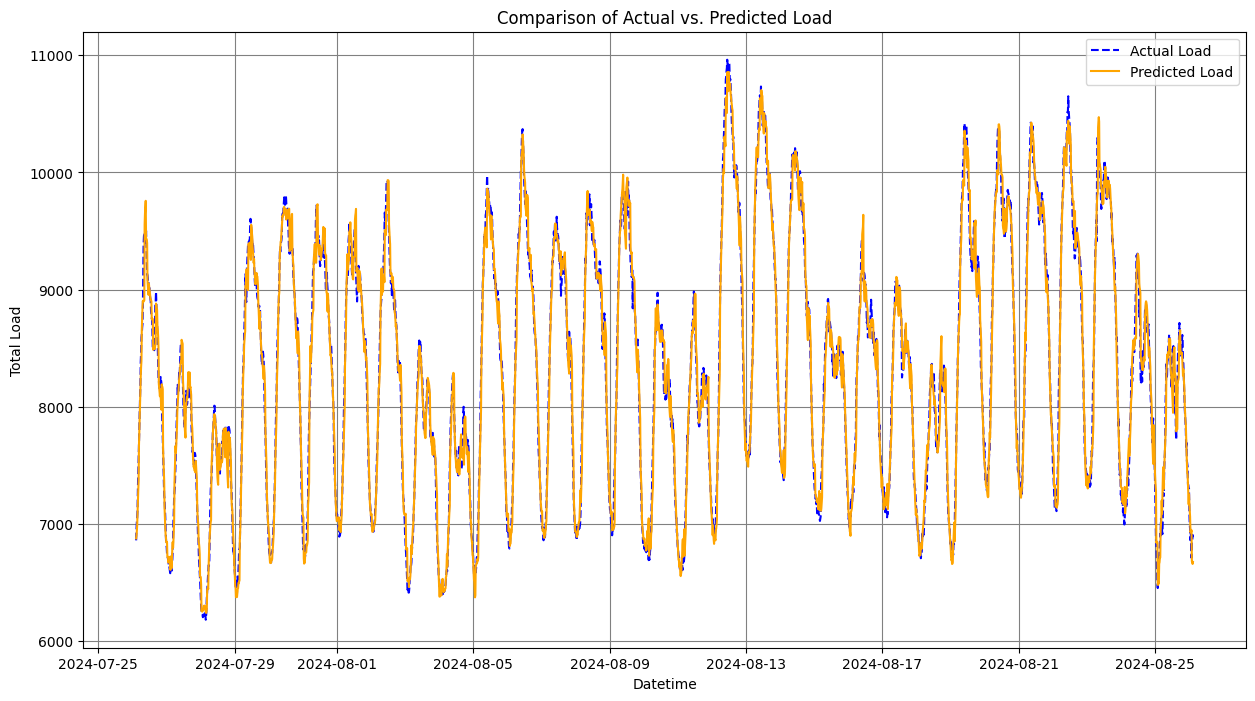

In [29]:
# Define the number of future steps to predict
n_future_steps = 2976  # 1 month
step_interval = 15  # Interval in minutes

# Start with the last available row of the test dataset to initialize predictions
last_row = data_test.iloc[-1:].copy()

# Initialize a list to store future predictions
future_predictions = []
actual_future_values = data_last_thirteen_months[data_last_thirteen_months['Datetime'] > data_test['Datetime'].max()].reset_index(drop=True)

# Perform forecasting using a mix of predicted and actual values
for step in range(n_future_steps):
    # Prepare input data for prediction
    X_input = last_row[feature_cols].values

    # Make the prediction
    predicted_value = best_lgbm.predict(X_input)[0]

    # Append the prediction to the future_predictions list
    future_predictions.append(predicted_value)

    # Every 4th step, reset with the actual value
    if (step + 1) % 4 == 0 and step < len(actual_future_values):
        actual_value = actual_future_values.iloc[step]['Total Load']
        last_row['lag_1'] = actual_value
    else:
        last_row['lag_1'] = predicted_value

    # Update the last_row to include the new prediction/actual value as the latest 'lag_1'
    # Shift the lag columns to the right
    for lag in range(num_lags, 1, -1):
        last_row[f'lag_{lag}'] = last_row[f'lag_{lag-1}']

# Prepare a DataFrame for the predicted values with appropriate timestamps
last_date = data_test['Datetime'].max()
future_datetimes = [last_date + pd.Timedelta(minutes=step_interval * (i + 1)) for i in range(n_future_steps)]
future_predictions_df = pd.DataFrame({'Datetime': future_datetimes, 'Predicted Load': future_predictions})

# Print the future predictions
print(future_predictions_df)

# Filter data_last_thirteen_months to include only the future Datetime values for comparison
actual_future_values = data_last_thirteen_months[data_last_thirteen_months['Datetime'].isin(future_predictions_df['Datetime'])]

# Merge future_predictions_df with actual_future_values on 'Datetime' to compare
comparison_df = pd.merge(future_predictions_df, actual_future_values[['Datetime', 'Total Load']], on='Datetime', how='left')

# Rename columns for clarity
comparison_df.rename(columns={'Total Load': 'Actual Load'}, inplace=True)

# Calculate the difference between predicted and actual values
comparison_df['Difference'] = comparison_df['Actual Load'] - comparison_df['Predicted Load']

# Print the comparison DataFrame
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(15, 8))
plt.plot(comparison_df['Datetime'], comparison_df['Actual Load'], label='Actual Load', color='blue', linestyle='--')
plt.plot(comparison_df['Datetime'], comparison_df['Predicted Load'], label='Predicted Load', color='orange', linestyle='-')
plt.title('Comparison of Actual vs. Predicted Load')
plt.xlabel('Datetime')
plt.ylabel('Total Load')
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(comparison_df['Actual Load'], comparison_df['Predicted Load'])

# Calculate normalized Mean Absolute Error (nMAE)
nmae = mae / comparison_df['Actual Load'].mean()

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(comparison_df['Actual Load'], comparison_df['Predicted Load'], squared=False)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Normalized Mean Absolute Error (nMAE): {nmae:.2%}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 104.64
Normalized Mean Absolute Error (nMAE): 1.26%
Root Mean Squared Error (RMSE): 140.65
